In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

C:\Users\Victor\.conda\envs\tech4\Lib\site-packages\requests\__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


In [3]:
# Configuração de seeds
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

In [4]:
# ========= 1. DOWNLOAD DOS DADOS =========
symbol = 'PETR4.SA'
start_date = '1901-01-01'
df = yf.download(symbol, start=start_date)

# Mantém apenas as colunas relevantes
df = df[['Close', 'High', 'Low', 'Open']].dropna()
df.index = pd.to_datetime(df.index)

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [5]:
# ========= 2. SEPARAÇÃO DE DADOS =========
# Dados até 31/12/2024 para treino/validação
train_val_df = df[df.index <= '2024-12-31']

# Dados de 2025 para teste final (validação "real")
test_df = df[df.index > '2024-12-31']

In [6]:
# ========= 3. ESCALONAMENTO =========
scaler = MinMaxScaler()
train_val_scaled = scaler.fit_transform(train_val_df.values)

In [ ]:
# ========= 4. CRIAÇÃO DAS SEQUÊNCIAS =========
def create_sequences(data, window_size=60):
    X, y = [], []
    for i in range(window_size, len(data)):
        X.append(data[i-window_size:i, :])
        y.append(data[i, 0])  # alvo: 'Close'
    return np.array(X), np.array(y) 

window_size = 60
X, y = create_sequences(train_val_scaled, window_size)

In [8]:
# ========= 5. SPLIT TREINO/VALIDAÇÃO =========
train_size = int(len(X) * 0.8)
X_train, X_val = X[:train_size], X[train_size:]
y_train, y_val = y[:train_size], y[train_size:]

In [9]:
# ========= 6. MODELO LSTM =========
model = Sequential([
    Input(shape=(window_size, 4)),
    LSTM(128, return_sequences=True),
    Dropout(0.1),
    LSTM(128, return_sequences=True),
    Dropout(0.1),
    LSTM(128),
    Dropout(0.1),
    Dense(1)
])
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Treinamento
history = model.fit(X_train, y_train,
                     epochs=100,
                     batch_size=32,
                     validation_data=(X_val, y_val),
                     callbacks=[early_stop])

Epoch 1/100
156/156 ━━━━━━━━━━━━━━━━━━━━ 14s 72ms/step - loss: 9.4786e-04 - val_loss: 0.0049
Epoch 2/100
156/156 ━━━━━━━━━━━━━━━━━━━━ 11s 68ms/step - loss: 1.1301e-04 - val_loss: 0.0036
Epoch 3/100
156/156 ━━━━━━━━━━━━━━━━━━━━ 10s 62ms/step - loss: 8.9386e-05 - val_loss: 0.0016
Epoch 4/100
156/156 ━━━━━━━━━━━━━━━━━━━━ 10s 64ms/step - loss: 1.0058e-04 - val_loss: 0.0040
Epoch 5/100
156/156 ━━━━━━━━━━━━━━━━━━━━ 10s 63ms/step - loss: 8.3278e-05 - val_loss: 0.0018
Epoch 6/100
156/156 ━━━━━━━━━━━━━━━━━━━━ 10s 64ms/step - loss: 7.1358e-05 - val_loss: 0.0026
Epoch 7/100
156/156 ━━━━━━━━━━━━━━━━━━━━ 10s 64ms/step - loss: 7.4835e-05 - val_loss: 0.0015
Epoch 8/100
156/156 ━━━━━━━━━━━━━━━━━━━━ 10s 66ms/step - loss: 6.0061e-05 - val_loss: 0.0017
Epoch 9/100
156/156 ━━━━━━━━━━━━━━━━━━━━ 11s 68ms/step - loss: 6.1211e-05 - val_loss: 6.9968e-04
Epoch 10/100
156/156 ━━━━━━━━━━━━━━━━━━━━ 11s 71ms/step - loss: 5.5335e-05 - val_loss: 5.1028e-04
Epoch 11/100
156/156 ━━━━━━━━━━━━━━━━━━━━ 11s 69ms/step - los

In [11]:
# ========= 7. PREVISÕES NA VALIDAÇÃO =========
y_pred_scaled = model.predict(X_val)
y_pred = y_pred_scaled.reshape(-1, 1)

# Inverte a normalização para 'Close'
close_min = scaler.data_min_[0]
close_max = scaler.data_max_[0]

y_pred_real = y_pred * (close_max - close_min) + close_min
y_val_real = y_val.reshape(-1, 1) * (close_max - close_min) + close_min

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step


In [12]:
# ========= 8. MÉTRICAS =========
mae = mean_absolute_error(y_val_real, y_pred_real)
rmse = np.sqrt(mean_squared_error(y_val_real, y_pred_real))
mape = np.mean(np.abs((y_val_real - y_pred_real) / y_val_real)) * 100
r2 = r2_score(y_val_real, y_pred_real)

print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.2f}%")
print(f"R²: {r2:.4f}")

MAE: 0.3293
RMSE: 0.4661
MAPE: 2.31%
R²: 0.9977


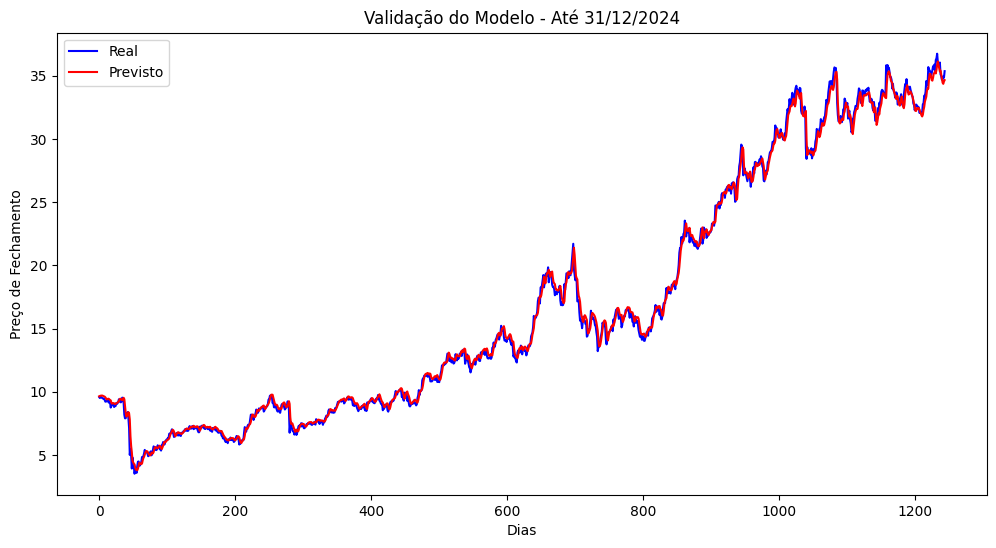

In [13]:
# ========= 9. GRÁFICO DE PREVISÕES =========
plt.figure(figsize=(12,6))
plt.plot(y_val_real, color='blue', label='Real')
plt.plot(y_pred_real, color='red', label='Previsto')
plt.title('Validação do Modelo - Até 31/12/2024')
plt.xlabel('Dias')
plt.ylabel('Preço de Fechamento')
plt.legend()
plt.show()

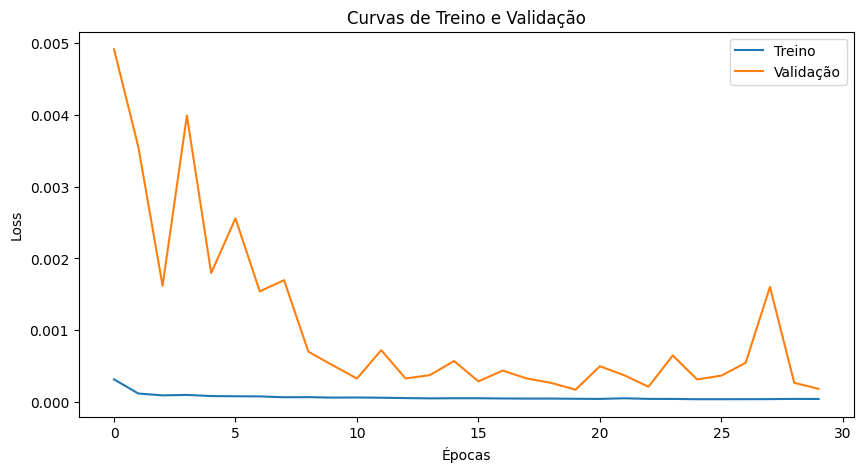

In [14]:
# ========= 10. CURVA DE TREINO =========
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'], label='Treino')
plt.plot(history.history['val_loss'], label='Validação')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.legend()
plt.title('Curvas de Treino e Validação')
plt.show()

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step

======= MÉTRICAS NO PERÍODO DE TESTE REAL (2025+) =======
MAE: 0.5093
RMSE: 0.6236
MAPE: 1.48%
R²: 0.9355


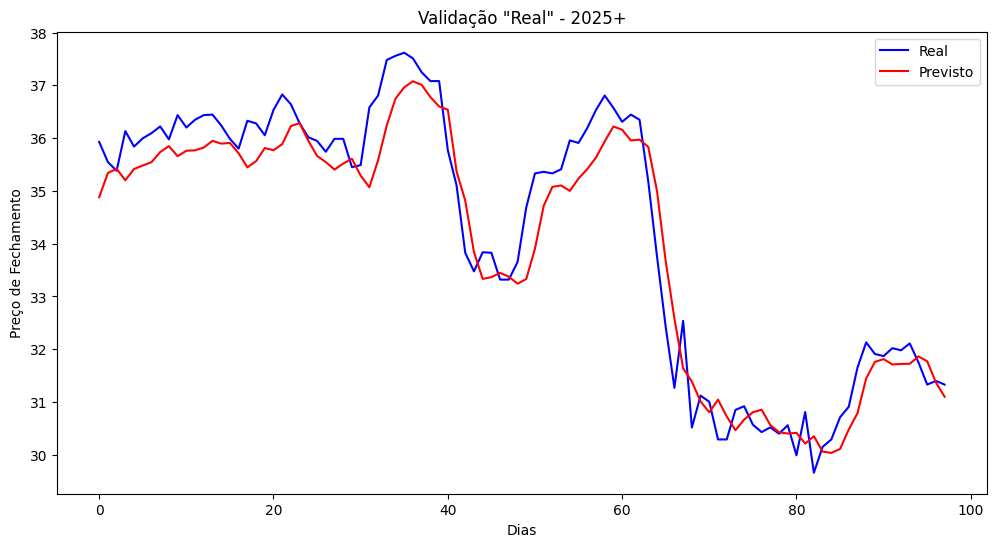

In [15]:
# ========= 11. TESTE COM DADOS "REAIS" DE 2025 =========
# Ajusta o dataframe para incluir janela anterior ao período de teste
df_test_full = pd.concat([train_val_df.tail(window_size), test_df])

# Escalona todos os dados novamente (usa mesmo scaler)
test_scaled = scaler.transform(df_test_full.values)

# Cria sequências para o período de teste (2025 em diante)
X_test, y_test = create_sequences(test_scaled, window_size)

# Previsões no período de teste
y_test_pred_scaled = model.predict(X_test)
y_test_pred = y_test_pred_scaled.reshape(-1, 1)

# Inverte normalização
y_test_pred_real = y_test_pred * (close_max - close_min) + close_min
y_test_real = y_test.reshape(-1, 1) * (close_max - close_min) + close_min

# Métricas no teste real
mae_test = mean_absolute_error(y_test_real, y_test_pred_real)
rmse_test = np.sqrt(mean_squared_error(y_test_real, y_test_pred_real))
mape_test = np.mean(np.abs((y_test_real - y_test_pred_real) / y_test_real)) * 100
r2_test = r2_score(y_test_real, y_test_pred_real)

print("\n======= MÉTRICAS NO PERÍODO DE TESTE REAL (2025+) =======")
print(f"MAE: {mae_test:.4f}")
print(f"RMSE: {rmse_test:.4f}")
print(f"MAPE: {mape_test:.2f}%")
print(f"R²: {r2_test:.4f}")

# Gráfico de previsões no teste real
plt.figure(figsize=(12,6))
plt.plot(y_test_real, color='blue', label='Real')
plt.plot(y_test_pred_real, color='red', label='Previsto')
plt.title('Validação "Real" - 2025+')
plt.xlabel('Dias')
plt.ylabel('Preço de Fechamento')
plt.legend()
plt.show()

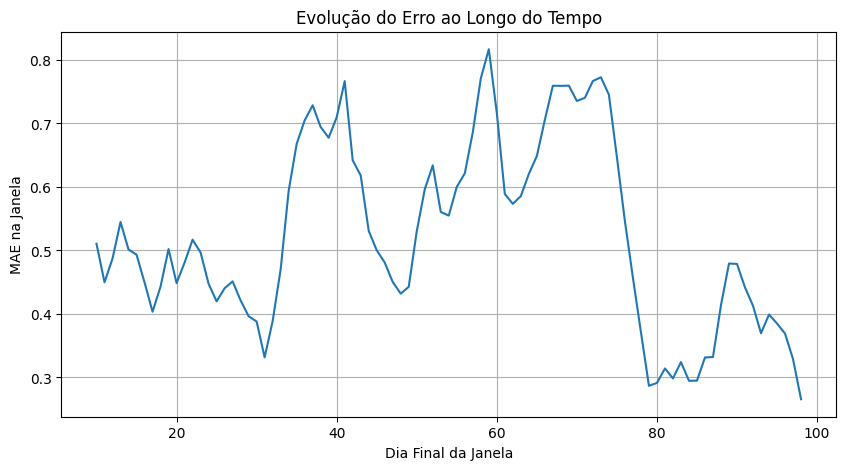

In [ ]:
window = 10  
mae_list = []
for i in range(0, len(y_test_real) - window + 1):
    real_window = y_test_real[i:i+window]
    pred_window = y_test_pred_real[i:i+window]
    mae_window = np.mean(np.abs(real_window - pred_window))
    mae_list.append(mae_window)

# Plota o erro ao longo do tempo
plt.figure(figsize=(10, 5))
plt.plot(range(window, len(y_test_real)+1), mae_list)
plt.xlabel('Dia Final da Janela')
plt.ylabel('MAE na Janela')
plt.title('Evolução do Erro ao Longo do Tempo')
plt.grid()
plt.show()
